In [6]:
import matplotlib as plt
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from libs.ds_charts import get_variable_types


# Missing values imputation

### Dataset 1

In [7]:
dataset_1 = pd.read_csv('dataset_1/NYC_collisions_tabular.csv', na_values='NaN')
new_dataset_1 = dataset_1.copy()

#FIND VARIABLES WITH MISSING VALUES
mv = {}
for var in new_dataset_1:
    nr = new_dataset_1[var].isna().sum()
    if nr > 0:
        mv[var] = nr

#DISCARD COLUMNS WITH MORE THEN 90% MISSING VALUES
threshold = new_dataset_1.shape[0] * 0.85

missings = [c for c in mv.keys() if mv[c]>threshold]
new_dataset_1.drop(columns=missings, inplace=True)
print('Dropped variables', missings)

#DISCARD RECORDS WITH MAJORITY OF MISSING VALUES
threshold = new_dataset_1.shape[1] * 0.50

new_dataset_1.dropna(thresh=threshold, inplace=True)
print(new_dataset_1.shape)

#PERSON_AGE
person_age = dataset_1['PERSON_AGE']
mean_ages = int(person_age.mean())
new_dataset_1['PERSON_AGE'].fillna(mean_ages,inplace=True)

#SAFETY_EQUIPMENT
new_dataset_1['SAFETY_EQUIPMENT'].fillna('Unknown',inplace=True)

#EJECTION
new_dataset_1['EJECTION'].fillna('Not Ejected',inplace=True)

#VEHICLE_ID
new_dataset_1['VEHICLE_ID'].dropna(inplace=True)

#POSITION IN VEHICLE
new_dataset_1['POSITION_IN_VEHICLE'].fillna('Unknown',inplace=True)
new_dataset_1.dropna(inplace=True)


Dropped variables ['PED_LOCATION', 'CONTRIBUTING_FACTOR_2', 'CONTRIBUTING_FACTOR_1', 'PED_ACTION']
(45669, 17)


### Dummification

In [8]:
file = 'nyc_collisions'
filename = 'data/nyc_collisions.csv'
symbolic_vars = ['BODILY_INJURY','SAFETY_EQUIPMENT','PERSON_SEX','PERSON_TYPE','EJECTION','COMPLAINT','EMOTIONAL_STATUS','POSITION_IN_VEHICLE','PED_ROLE','PERSON_INJURY']

def dummify(df, vars_to_dummify):
    other_vars = [c for c in df.columns if not c in vars_to_dummify]
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=bool)
    X = df[vars_to_dummify]
    encoder.fit(X)
    new_vars = encoder.get_feature_names_out(vars_to_dummify)
    trans_X = encoder.transform(X)
    dummy = pd.DataFrame(trans_X, columns=new_vars, index=X.index)
    dummy = dummy.convert_dtypes(convert_boolean=True)

    final_df = pd.concat([df[other_vars], dummy], axis=1)
    return final_df

variables = get_variable_types(new_dataset_1)
new_dataset_1 = dummify(new_dataset_1, symbolic_vars)
new_dataset_1.to_csv(f'data/{file}_dummified.csv', index=False)
nr = new_dataset_1.isna().sum()
print(nr)
#df.describe(include=[bool])

CRASH_DATE                     0
CRASH_TIME                     0
PERSON_AGE                     0
VEHICLE_ID                     0
PERSON_ID                      0
                              ..
POSITION_IN_VEHICLE_Unknown    0
PED_ROLE_Driver                0
PED_ROLE_Passenger             0
PERSON_INJURY_Injured          0
PERSON_INJURY_Killed           0
Length: 88, dtype: int64


## Scalling

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

'''
 we need to apply the transfomation and rejoin the data together in order
 to have a unique dataframe. They can only be applied to numerical data, 
 without any missing value. In order to do that, we are splitting our dataframe into three 
 dataframes, one for each data type: above, discarding date variables, since the majority of 
 techniques are not able to deal with them.
'''
variable_types = get_variable_types(new_dataset_1)
numeric_vars = variable_types['Numeric']
symbolic_vars2 = variable_types['Symbolic']
boolean_vars = variable_types['Binary']

df_nr = new_dataset_1[numeric_vars]
df_sb = new_dataset_1[symbolic_vars2]
df_bool = new_dataset_1[boolean_vars]

          PERSON_AGE    VEHICLE_ID     UNIQUE_ID  COLLISION_ID  \
count   39098.000000  39098.000000  39098.000000  39098.000000   
unique           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN   
mean        0.091867      0.606572      0.605583      0.519832   
std         0.007914      0.275769      0.275490      0.278076   
min         0.000000      0.000000      0.000000      0.000000   
25%         0.090793      0.482073      0.482147      0.289430   
50%         0.091522      0.648725      0.647266      0.526596   
75%         0.092707      0.822050      0.819945      0.756462   
max         1.000000      1.000000      1.000000      1.000000   

       BODILY_INJURY_Abdomen - Pelvis BODILY_INJURY_Back BODILY_INJURY_Chest  \
count                           39098              39098               39098   
unique                              2          

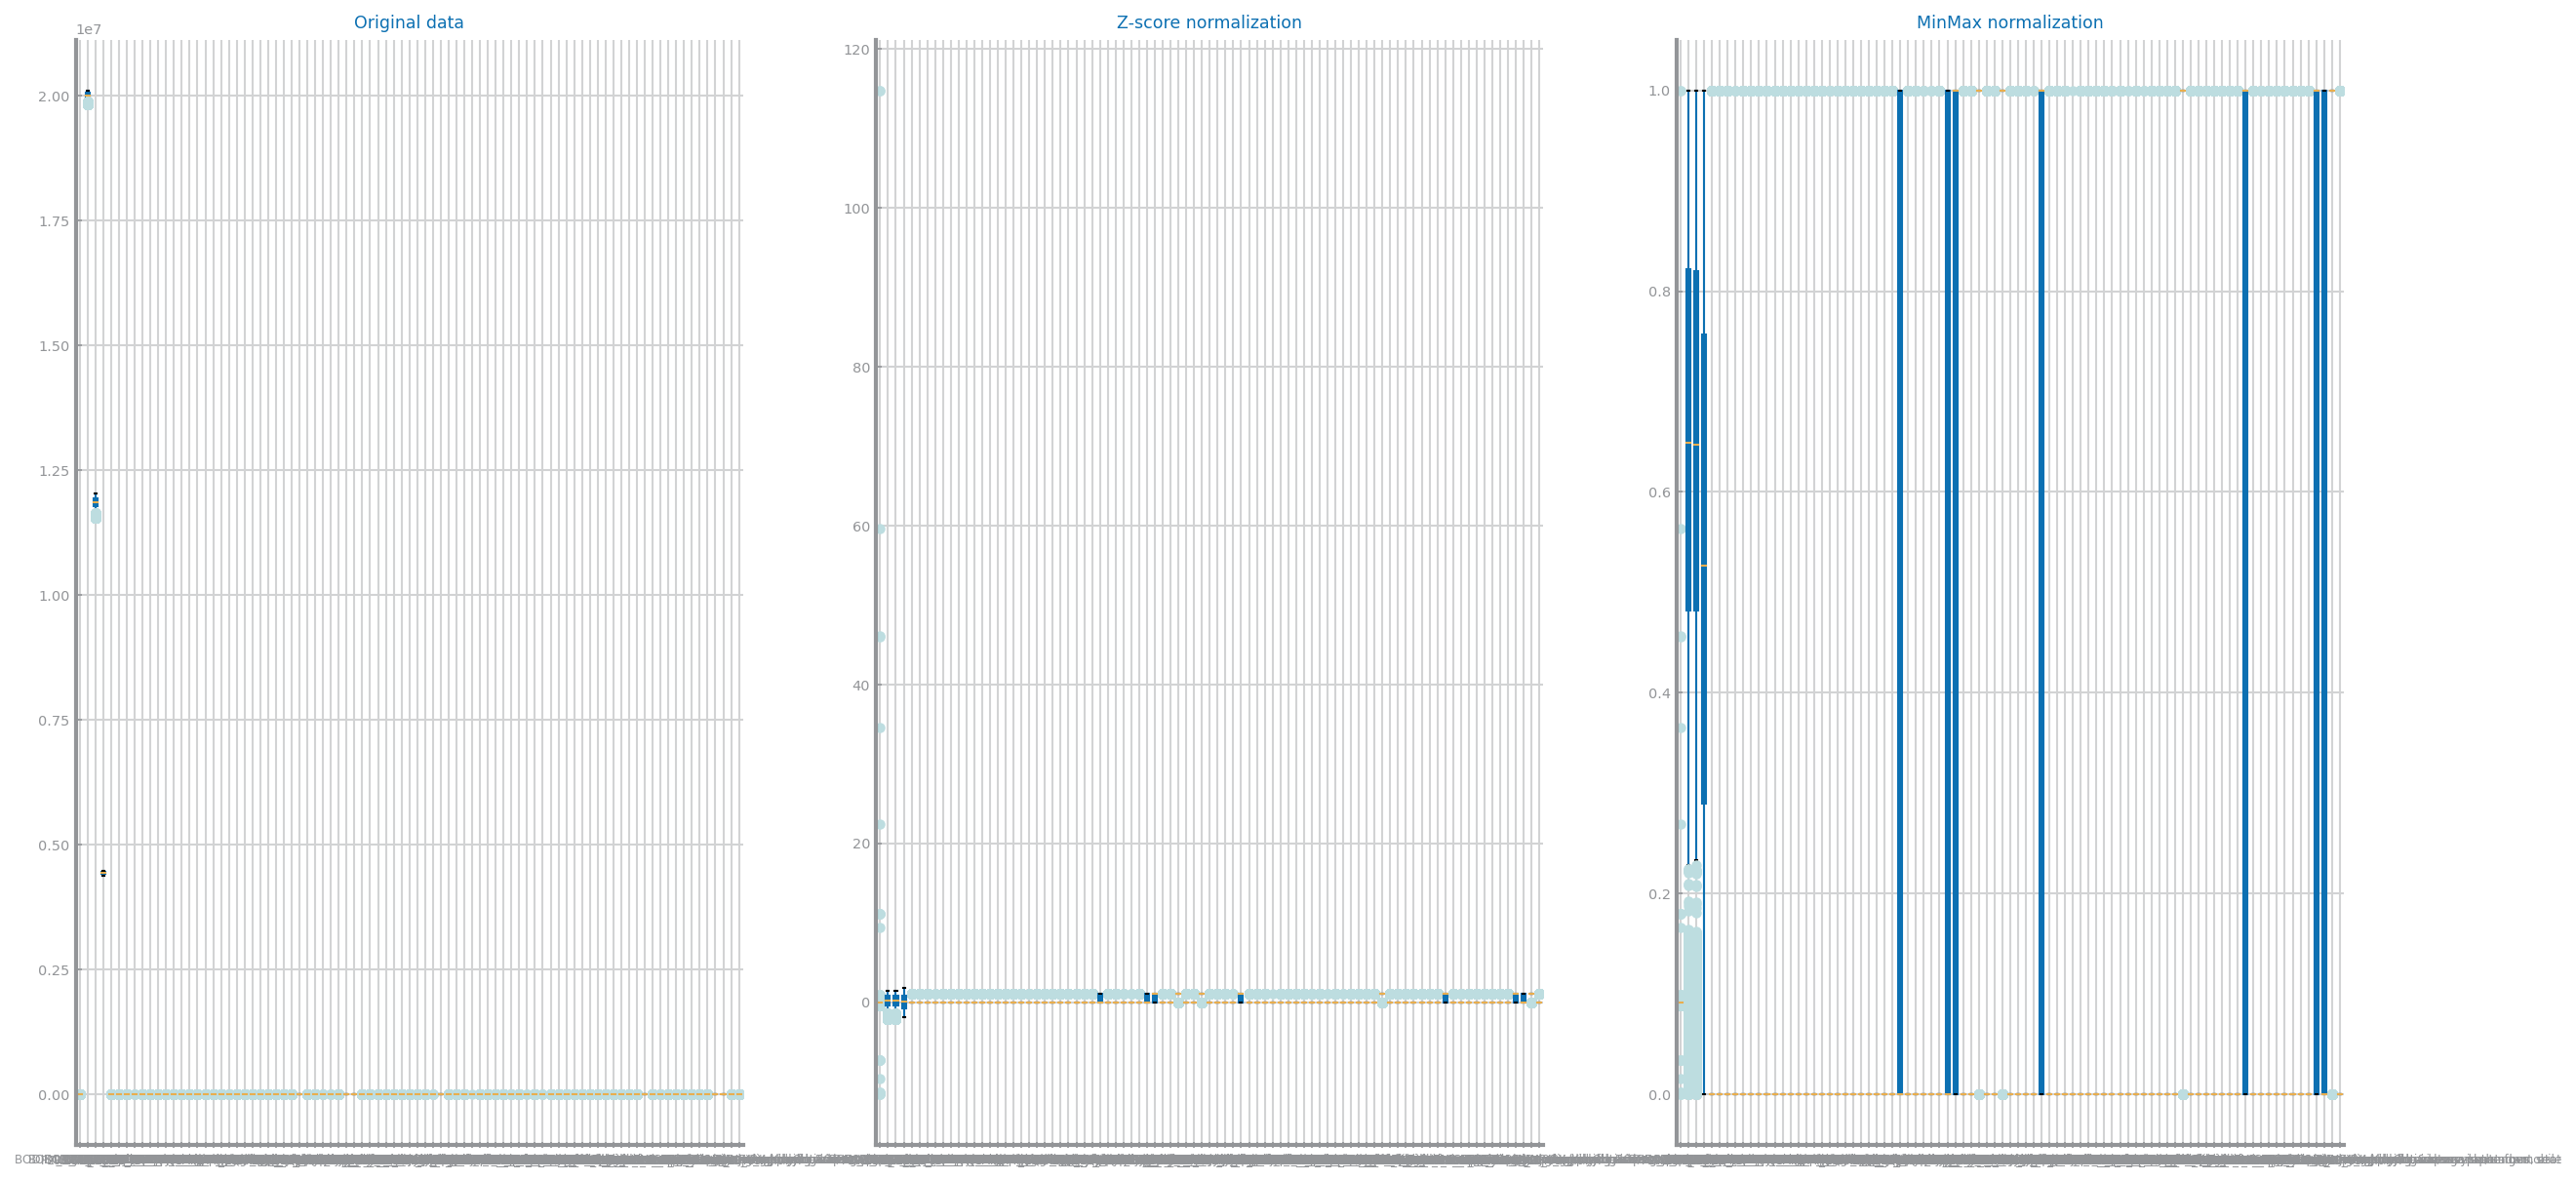

In [10]:
transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
tmp = pd.DataFrame(transf.transform(df_nr), index=new_dataset_1.index, columns= numeric_vars)
norm_data_zscore = pd.concat([tmp, df_sb,  df_bool], axis=1)
norm_data_zscore.to_csv(f'data/{file}_scaled_zscore.csv', index=False)

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = pd.DataFrame(transf.transform(df_nr), index=new_dataset_1.index, columns= numeric_vars)
norm_data_minmax = pd.concat([tmp, df_sb,  df_bool], axis=1)
norm_data_minmax.to_csv(f'data/{file}_scaled_minmax.csv', index=False)
print(norm_data_minmax.describe())
df = new_dataset_1
# Now we can se the result of the transformed data with a single boxplot, again.

fig, axs = plt.pyplot.subplots(1, 3, figsize=(20,10),squeeze=False)
axs[0, 0].set_title('Original data')
df.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title('MinMax normalization')
norm_data_minmax.boxplot(ax=axs[0, 2])
plt.pyplot.show()